# **COVID-19 Mortality Prediction using Machine Learning**
Author: Vinicius Calado Nogueira de Moura

Advisor: Gabriel Ferreira Dos Santos Silva

MBA in Data Science and Analytics - USP/ESALQ

## Steps in the analysis:

1. Loading datasets

2. Exploratory Data Analysis and Data Wrangling

3. Statistical Analysis

4. Machine Learning Models


# 1. Loading datasets
___
- Datasets can be found at: https://opendatasus.saude.gov.br/dataset 
- Search for "Síndrome respiratória aguda grave"

In [1]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

In [2]:
srag21 = pd.read_csv('SRAG_2021.csv', delimiter=';', dtype=str)
srag21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733517 entries, 0 to 1733516
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: object(166)
memory usage: 2.1+ GB


In [3]:
srag22 = pd.read_csv('SRAG_2022.csv', delimiter=';', dtype=str)
srag22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542162 entries, 0 to 542161
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: object(166)
memory usage: 686.6+ MB


In [4]:
df = pd.concat([srag21, srag22])
df.index = pd.RangeIndex(start=0, stop=df.shape[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2275679 entries, 0 to 2275678
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: object(166)
memory usage: 2.8+ GB


# 2. Exploratory Data Analysis and Data Wrangling
___

Steps: 
1. Evaluate proportion of missing values - df[variable].isna( ).sum( )/df.shape[0]
2. Evaluate the counts of each category
3. Add category names from the data dictionary
4. Obtain the final dataset by removing observations with inconsistencies and potential data entry errors

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [6]:
# Setting Seaborn Figure Parameters
sns.set(rc={"figure.figsize":(8, 4)})
sns.set_context('paper')
custom_params = {'axes.spines.right': False, 
                 'axes.spines.top': False, 
                 'axes.linewidth': 1.5}
sns.set_theme(style="white", rc=custom_params)

In [7]:
# Selecting data starting on July 1, 2021 to balance the number of vaccinated people
start_date = datetime(year=2021, month=7, day=1)
df['DT_SIN_PRI'] = pd.to_datetime(df['DT_SIN_PRI'], format='%d/%m/%Y')
df = df[df['DT_SIN_PRI'] >= start_date].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 978220 entries, 90 to 2275678
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: datetime64[ns](1), object(165)
memory usage: 1.2+ GB


### Confirmed COVID-19 cases: 
1 - Severe accute respiratory syndrome caused by influenza

2 - Severe accute respiratory syndrome caused by other respiratory virus

3 - Severe accute respiratory syndrome caused by other agent, specify:

4 - Severe accute respiratory syndrome not specified

5 - Severe accute respiratory syndrome caused by SARS-CoV2

In [8]:
# Including only confirmed COVID-19 cases
df = df[df['CLASSI_FIN'] == '5'].copy() 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426366 entries, 8354 to 2275678
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: datetime64[ns](1), object(165)
memory usage: 543.2+ MB


### Confirmed hospitalizations: 
1 - yes 

2 - no

9 - ignored

In [9]:
# Including only cases that were confirmed hospitalizations
df = df[df['HOSPITAL'] == '1'].copy() 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 410959 entries, 8354 to 2275678
Columns: 166 entries, DT_NOTIFIC to FNT_IN_COV
dtypes: datetime64[ns](1), object(165)
memory usage: 523.6+ MB


## 2.1 Target Variable: Death

1 - cure

2 - death

3 - death by other causes

9 - ignored

In [10]:
# Checking the percentage of missing values
df['EVOLUCAO'].isna().sum()/df.shape[0]

0.06008628597986661

In [11]:
df['EVOLUCAO'].value_counts()

1    265222
2    107238
9     10175
3      3631
Name: EVOLUCAO, dtype: int64

In [12]:
outcome_dict = {'1': 'survival',
                '2': 'death',
                '3': 'death_other'}
df['outcome'] = df['EVOLUCAO'].apply(outcome_dict.get)
df['outcome'].value_counts()

survival       265222
death          107238
death_other      3631
Name: outcome, dtype: int64

In [13]:
df['outcome'].describe()

count       376091
unique           3
top       survival
freq        265222
Name: outcome, dtype: object

## 2.2 Demographics

### Age

In [14]:
df['NU_IDADE_N'].isna().sum()/df.shape[0]

0.0

In [15]:
# Converting age to numerical values
df['age'] = pd.to_numeric(df['NU_IDADE_N'])
df['age'].describe()

count    410959.000000
mean         60.362671
std          23.265814
min          -9.000000
25%          45.000000
50%          65.000000
75%          78.000000
max         136.000000
Name: age, dtype: float64

Age <0 and >100 could indicate potential data entry errors

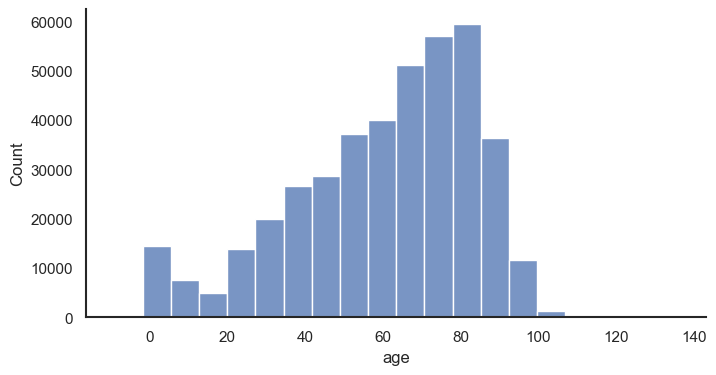

In [16]:
sns.histplot(data=df, x='age', bins=20);

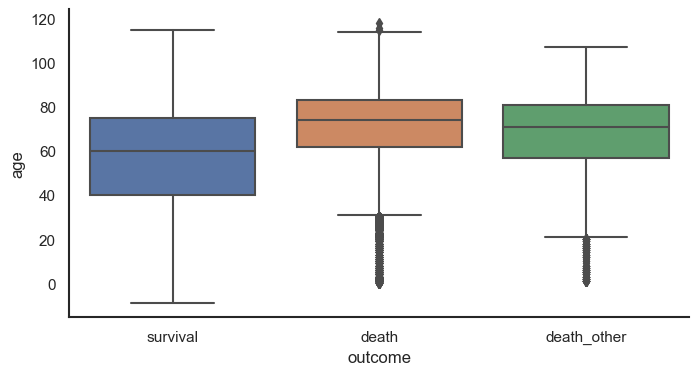

In [17]:
sns.boxplot(data=df, x='outcome', y='age');

In [18]:
df.groupby(['outcome'])['age'].mean()

outcome
death          70.929036
death_other    66.593776
survival       56.130355
Name: age, dtype: float64

### Sex

In [19]:
# Checking the percentage of missing values
df['CS_SEXO'].isna().sum()/df.shape[0]

0.0

In [20]:
df['CS_SEXO'].value_counts()

M    216114
F    194810
I        35
Name: CS_SEXO, dtype: int64

In [21]:
sex_dict = {'M': 'male', 
            'F': 'female'}
df['sex'] = df['CS_SEXO'].apply(sex_dict.get)
df['sex'] = pd.Categorical(df['sex'])
df['sex'].value_counts()

male      216114
female    194810
Name: sex, dtype: int64

### Race

1 - white
 
2 - black
 
3 - asian
 
4 - mixed
 
5 - indigenous
 
9 - ignored

In [22]:
df['CS_RACA'].isna().sum()/df.shape[0]

0.0

In [23]:
df['CS_RACA'].value_counts()

1    190167
4    130560
9     69555
2     15951
3      3921
5       805
Name: CS_RACA, dtype: int64

In [24]:
race_dict = {'1': 'white', '2': 'black',
             '3': 'asian', '4': 'mixed',
             '5': 'indigenous'}
df['race'] = df['CS_RACA'].apply(lambda x: race_dict.get(x))
df['race'] = pd.Categorical(df['race'])
df['race'].value_counts()

white         190167
mixed         130560
black          15951
asian           3921
indigenous       805
Name: race, dtype: int64

### Education

1 - illiterate

2 - 5_grade

3 - 9_grade

4 - 12_grade

5 - not_applicable

9 - ignored

In [25]:
df['CS_ESCOL_N'].isna().sum()/df.shape[0]

0.35971958273209736

In [26]:
df['CS_ESCOL_N'].value_counts()

9    122038
1     41567
3     37529
2     24867
4     16682
0     14429
5      6017
Name: CS_ESCOL_N, dtype: int64

In [27]:
ed_dict = {'0': 'illiterate', 
           '1': '5_grade', 
           '2': '9_grade', 
           '3': '12_grade', 
           '4': 'higher_ed'}
df['education'] = df['CS_ESCOL_N'].apply(lambda x: ed_dict.get(x))
school_cat = ['illiterate', '5_grade', 
              '9_grade', '12_grade', 'higher_ed']
df['education'] = pd.Categorical(df['education'], categories=school_cat)
df['education'].value_counts().sort_index()

illiterate    14429
5_grade       41567
9_grade       24867
12_grade      37529
higher_ed     16682
Name: education, dtype: int64

## 2.3 Vaccination Status

1 - vaccinated

2 - unvaccinated

9 - ignored

In [28]:
df['VACINA_COV'].isna().sum()/df.shape[0]

0.03069892617025056

In [29]:
vaccination_dict = {'1': 'vaccinated', 
                    '2': 'unvaccinated'}
df['vaccination_status'] = df['VACINA_COV'].apply(lambda x: vaccination_dict.get(x))
df['vaccination_status'] = pd.Categorical(df['vaccination_status'], categories=['vaccinated', 'unvaccinated'])
df['vaccination_status'].value_counts()

vaccinated      262032
unvaccinated    108250
Name: vaccination_status, dtype: int64

In [30]:
df['vaccination_status'].isna().sum()/df.shape[0]

0.09898067690450872

### Presence of vaccination dates

In [31]:
df['first_dose_date'] = df['DOSE_1_COV'].apply(lambda x: 0 if pd.isna(x) else 1)
df['first_dose_date'].value_counts()

1    237758
0    173201
Name: first_dose_date, dtype: int64

In [32]:
df.groupby(['vaccination_status'])['first_dose_date'].value_counts()

vaccination_status  first_dose_date
vaccinated          1                  237478
                    0                   24554
unvaccinated        0                  108097
                    1                     153
Name: first_dose_date, dtype: int64

- There are vaccinated patients with no date of first_dose 
- There are unvaccinated patients with date of first_dose 

In [33]:
df['second_dose_date'] = df['DOSE_2_COV'].apply(lambda x: 0 if pd.isna(x) else 1)
df['second_dose_date'].value_counts()

0    205981
1    204978
Name: second_dose_date, dtype: int64

In [34]:
df.groupby(['first_dose_date'])['second_dose_date'].value_counts()

first_dose_date  second_dose_date
0                0                   168596
                 1                     4605
1                1                   200373
                 0                    37385
Name: second_dose_date, dtype: int64

- There are patients with date of second_dose without date of first_dose

In [35]:
df['booster_date'] = df['DOSE_REF'].apply(lambda x: 0 if pd.isna(x) else 1)
df['booster_date'].value_counts()

0    334921
1     76038
Name: booster_date, dtype: int64

In [36]:
df.groupby(['second_dose_date'])['booster_date'].value_counts()

second_dose_date  booster_date
0                 0               203195
                  1                 2786
1                 0               131726
                  1                73252
Name: booster_date, dtype: int64

- There are patients with date of booster without date of second_dose

Inconsistencies found: 
- Vaccinated with empty first_dose_date 
- Unvaccinated with first_dose_date 
- first_dose_date == 0 and second_dose_date == 1
- second_dose_date == 0 and booster_date == 1

### Vaccine Manufacturers

#### First dose

In [37]:
df['FAB_COV_1'].nunique()

3630

In [38]:
df['FAB_COV_1'].value_counts().head(20)

86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC        79235
85 - COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD    55052
CORONAVAC                                         17903
87 - COVID-19 PFIZER - COMIRNATY                  16509
BUTANTAN                                          11315
ASTRAZENECA                                        9418
PFIZER                                             4901
FIOCRUZ                                            4559
ASTRAZENICA                                        3700
86 - COVID-19-CORONAVAC-SINOVAC/BUTANTAN           2664
89 - COVID-19 ASTRAZENECA - CHADOX1-S              2439
SINOVAC/BUTANTAN                                   2020
SINOVAC                                            1869
OXFORD                                             1425
COVID-19-CORONAVAC-SINOVAC/BUTANTAN                1226
85 - VACINA COVID-19 - COVISHIELD                  1220
ASTRAZENECA/OXFORD/FIOCRUZ                         1174
OXFORD/FIOCRUZ                                  

#### Second dose

In [39]:
df['FAB_COV_2'].nunique()

284

In [40]:
df['FAB_COV_2'].value_counts().head(20)

86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC        59909
85 - COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD    38188
87 - COVID-19 PFIZER - COMIRNATY                   9677
89 - COVID-19 ASTRAZENECA - CHADOX1-S              3298
CORONAVAC                                          1303
BUTANTAN                                            660
ASTRAZENECA                                         607
PFIZER                                              344
99 - COVID-19 PEDIATRICA - PFIZER COMIRNATY         295
FIOCRUZ                                             269
INSTITUTO BUTANTAN                                  246
ASTRAZENICA                                         192
ASTRAZENECA/OXFORD/FIOCRUZ                          159
SINOVAC/BUTANTAN                                    148
SINOVAC                                             114
VACINA COVID-19 BUTANTAN                             95
FUNDACAO OSWALDO CRUZ                                92
ASTRAZENECA/FIOCRUZ                             

#### Booster

In [41]:
df['FAB_COVREF'].nunique()

156

In [42]:
df['FAB_COVREF'].value_counts().head(20)

87 - COVID-19 PFIZER - COMIRNATY                  55109
86 - COVID-19 SINOVAC/BUTANTAN - CORONAVAC         7014
88 - COVID-19 JANSSEN - AD26.COV2.S                6019
85 - COVID-19 ASTRAZENECA/FIOCRUZ - COVISHIELD     4764
PFIZER                                             1719
CORONAVAC                                           320
PFIZER MANUFACTURING BELGIUM NV - BELGICA           151
JANSSEN                                              78
ASTRAZENECA                                          52
VACINA COVID-19 PFIZER                               45
VACINA COVID-19-RNAM, PFIZER (COMIRNATY)             45
89 - COVID-19 ASTRAZENECA - CHADOX1-S                30
SINOVAC/BUTANTAN                                     29
SINOVAC                                              27
BUTANTAN                                             24
FIOCRUZ                                              19
98 - COVID-19 SINOVAC - CORONAVAC                    18
ASTRAZENICA                                     

## 2.4 Comorbidities

1 - yes

2 - no

9 - ignored

### Obesity 

In [43]:
df['OBESIDADE'].isna().sum() / df.shape[0]

0.5986485269820103

In [44]:
df['OBESIDADE'].value_counts()

2    134072
1     27019
9      3848
Name: OBESIDADE, dtype: int64

In [45]:
obesity_dict = {'1': 'obesity', 
                '2': 'no_obesity'}
df['obesity'] = df['OBESIDADE'].apply(obesity_dict.get)

obesity_cat = ['obesity', 'no_obesity'] 
df['obesity'] = pd.Categorical(df['obesity'], categories=obesity_cat)
df['obesity'].value_counts()

no_obesity    134072
obesity        27019
Name: obesity, dtype: int64

### BMI

In [46]:
df['bmi'] = df['OBES_IMC'].str.replace(',', '.')
df['bmi'] = pd.to_numeric(df['bmi'])
df['bmi'].describe()

count    4000.000000
mean       29.363875
std        17.275442
min         0.000000
25%        28.500000
50%        32.400000
75%        38.100000
max       329.000000
Name: bmi, dtype: float64

In [47]:
df.groupby(['OBESIDADE'])['bmi'].mean()

OBESIDADE
1    29.363875
2          NaN
9          NaN
Name: bmi, dtype: float64

- BMI is only filled out for patients with obesity

In [48]:
df.groupby(['outcome'])['bmi'].mean()

outcome
death          30.575798
death_other    31.381250
survival       29.094296
Name: bmi, dtype: float64

In [49]:
df['bmi'].describe()

count    4000.000000
mean       29.363875
std        17.275442
min         0.000000
25%        28.500000
50%        32.400000
75%        38.100000
max       329.000000
Name: bmi, dtype: float64

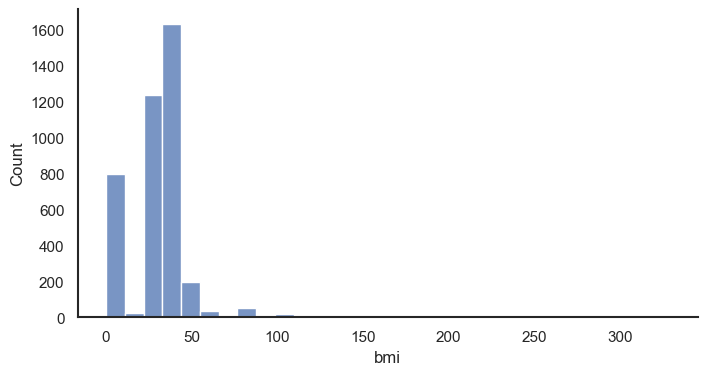

In [50]:
sns.histplot(data=df, x='bmi', bins=30);

BMI is not a reliable variable because: 
- It's only filled out in patients with obesity
- Many values are close to 0, which does not match the obesity criteria of BMI >=30
- May include calculation errors

### Diabetes

In [51]:
df['DIABETES'].isna().sum()/df.shape[0]

0.5293837098104677

In [52]:
df['DIABETES'].value_counts()

2    100443
1     90920
9      2041
Name: DIABETES, dtype: int64

In [53]:
diabetes_dict = {'1': 'diabetes', 
                 '2': 'no_diabetes'}
df['diabetes'] = df['DIABETES'].apply(diabetes_dict.get)

diabetes_cat = ['diabetes', 'no_diabetes'] 
df['diabetes'] = pd.Categorical(df['diabetes'], categories=diabetes_cat)
df['diabetes'].value_counts()

no_diabetes    100443
diabetes        90920
Name: diabetes, dtype: int64

### Heart disease

In [54]:
df['CARDIOPATI'].isna().sum()/df.shape[0]

0.4875109195807854

In [55]:
df['CARDIOPATI'].value_counts()

1    135388
2     73461
9      1763
Name: CARDIOPATI, dtype: int64

In [56]:
heart_disease_dict = {'1': 'heart_disease', 
                      '2': 'no_heart_disease'}
df['heart_disease'] = df['CARDIOPATI'].apply(heart_disease_dict.get)

heart_disease_cat = ['heart_disease', 'no_heart_disease'] 
df['heart_disease'] = pd.Categorical(df['heart_disease'], categories=heart_disease_cat)
df['heart_disease'].value_counts()

heart_disease       135388
no_heart_disease     73461
Name: heart_disease, dtype: int64

### Lung disease

In [57]:
df['PNEUMOPATI'].isna().sum()/df.shape[0]

0.6015076929815383

In [58]:
df['PNEUMOPATI'].value_counts()

2    141417
1     19379
9      2968
Name: PNEUMOPATI, dtype: int64

In [59]:
lung_disease_dict = {'1': 'lung_disease', 
                      '2': 'no_lung_disease'}
df['lung_disease'] = df['PNEUMOPATI'].apply(lung_disease_dict.get)

lung_disease_cat = ['lung_disease', 'no_lung_disease'] 
df['lung_disease'] = pd.Categorical(df['lung_disease'], categories=lung_disease_cat)
df['lung_disease'].value_counts()

no_lung_disease    141417
lung_disease        19379
Name: lung_disease, dtype: int64

### Kidney disease

In [60]:
df['RENAL'].isna().sum()/df.shape[0]

0.6028873926596083

In [61]:
df['RENAL'].value_counts()

2    141641
1     18690
9      2866
Name: RENAL, dtype: int64

In [62]:
kidney_disease_dict = {'1': 'kidney_disease', 
                       '2': 'no_kidney_disease'}
df['kidney_disease'] = df['RENAL'].apply(kidney_disease_dict.get)

kidney_disease_cat = ['kidney_disease', 'no_kidney_disease'] 
df['kidney_disease'] = pd.Categorical(df['kidney_disease'], categories=kidney_disease_cat)
df['kidney_disease'].value_counts()

no_kidney_disease    141641
kidney_disease        18690
Name: kidney_disease, dtype: int64

### Liver disease

In [63]:
df['HEPATICA'].isna().sum()/df.shape[0]

0.6162366562114469

In [64]:
df['HEPATICA'].value_counts()

2    150716
1      3894
9      3101
Name: HEPATICA, dtype: int64

In [65]:
liver_disease_dict = {'1': 'liver_disease', 
                       '2': 'no_liver_disease'}
df['liver_disease'] = df['HEPATICA'].apply(liver_disease_dict.get)

liver_disease_cat = ['liver_disease', 'no_liver_disease'] 
df['liver_disease'] = pd.Categorical(df['liver_disease'], categories=liver_disease_cat)
df['liver_disease'].value_counts()

no_liver_disease    150716
liver_disease         3894
Name: liver_disease, dtype: int64

### Blood disease

In [66]:
df['HEMATOLOGI'].isna().sum()/df.shape[0]

0.6147352898950991

In [67]:
df['HEMATOLOGI'].value_counts()

2    151355
1      3855
9      3118
Name: HEMATOLOGI, dtype: int64

In [68]:
blood_disease_dict = {'1': 'blood_disease', 
                      '2': 'no_blood_disease'}
df['blood_disease'] = df['HEMATOLOGI'].apply(blood_disease_dict.get)

blood_disease_cat = ['blood_disease', 'no_blood_disease'] 
df['blood_disease'] = pd.Categorical(df['blood_disease'], categories=blood_disease_cat)
df['blood_disease'].value_counts()

no_blood_disease    151355
blood_disease         3855
Name: blood_disease, dtype: int64

### Immunocompromised

In [69]:
df['IMUNODEPRE'].isna().sum()/df.shape[0]

0.606870758396823

In [70]:
df['IMUNODEPRE'].value_counts()

2    143766
1     14679
9      3115
Name: IMUNODEPRE, dtype: int64

In [71]:
immuno_dict = {'1': 'immunocompromised', 
               '2': 'no_immunocompromised'}
df['immunocompromised'] = df['IMUNODEPRE'].apply(immuno_dict.get)

immuno_cat = ['immunocompromised', 'no_immunocompromised'] 
df['immunocompromised'] = pd.Categorical(df['immunocompromised'], categories=immuno_cat)
df['immunocompromised'].value_counts()

no_immunocompromised    143766
immunocompromised        14679
Name: immunocompromised, dtype: int64

### Asthma

In [72]:
df['ASMA'].isna().sum()/df.shape[0]

0.6107324574957599

In [73]:
df['ASMA'].value_counts()

2    146375
1     10621
9      2977
Name: ASMA, dtype: int64

In [74]:
asthma_dict = {'1': 'asthma', 
               '2': 'no_asthma'}
df['asthma'] = df['ASMA'].apply(asthma_dict.get)

asthma_cat = ['asthma', 'no_asthma'] 
df['asthma'] = pd.Categorical(df['asthma'], categories=asthma_cat)
df['asthma'].value_counts()

no_asthma    146375
asthma        10621
Name: asthma, dtype: int64

### Pregnancy

In [75]:
df['PUERPERA'].isna().sum()/df.shape[0]

0.6160687562506235

In [76]:
df['PUERPERA'].value_counts()

2    152999
9      2876
1      1905
Name: PUERPERA, dtype: int64

In [77]:
pregnancy_dict = {'1': 'pregnancy', 
                  '2': 'no_pregnancy'}
df['pregnancy'] = df['PUERPERA'].apply(pregnancy_dict.get)

pregnancy_cat = ['pregnancy', 'no_pregnancy'] 
df['pregnancy'] = pd.Categorical(df['pregnancy'], categories=pregnancy_cat)
df['pregnancy'].value_counts()

no_pregnancy    152999
pregnancy         1905
Name: pregnancy, dtype: int64

### Neurological disease

In [78]:
df['NEUROLOGIC'].isna().sum()/df.shape[0]

0.5973904939422181

In [79]:
df['NEUROLOGIC'].value_counts()

2    138617
1     23926
9      2913
Name: NEUROLOGIC, dtype: int64

In [80]:
neuro_dict = {'1': 'neuro_disease', 
               '2': 'no_neuro_disease'}
df['neuro_disease'] = df['NEUROLOGIC'].apply(neuro_dict.get)

neuro_disease_cat = ['neuro_disease', 'no_neuro_disease'] 
df['neuro_disease'] = pd.Categorical(df['neuro_disease'], categories=neuro_disease_cat)
df['neuro_disease'].value_counts()

no_neuro_disease    138617
neuro_disease        23926
Name: neuro_disease, dtype: int64

## 2.5 Signs and Symptoms:

1 - yes

2 - no

9 - ignored

### Fever

In [81]:
df['FEBRE'].isna().sum()/df.shape[0]

0.19901012023097195

In [82]:
df['FEBRE'].value_counts()

1    197773
2    126835
9      4566
Name: FEBRE, dtype: int64

In [83]:
fever_dict = {'1': 'fever', 
              '2': 'no_fever'}
df['fever'] = df['FEBRE'].apply(fever_dict.get)

fever_cat = ['fever', 'no_fever'] 
df['fever'] = pd.Categorical(df['fever'], categories=fever_cat)
df['fever'].value_counts()

fever       197773
no_fever    126835
Name: fever, dtype: int64

### Cough

In [84]:
df['TOSSE'].isna().sum()/df.shape[0]

0.14419929968683007

In [85]:
df['TOSSE'].value_counts()

1    269840
2     78316
9      3543
Name: TOSSE, dtype: int64

In [86]:
cough_dict = {'1': 'cough', 
               '2': 'no_cough'}
df['cough'] = df['TOSSE'].apply(cough_dict.get)

cough_cat = ['cough', 'no_cough'] 
df['cough'] = pd.Categorical(df['cough'], categories=cough_cat)
df['cough'].value_counts()

cough       269840
no_cough     78316
Name: cough, dtype: int64

### Sore Throat

In [87]:
df['GARGANTA'].isna().sum()/df.shape[0]

0.31441822663574714

In [88]:
df['GARGANTA'].value_counts()

2    207786
1     66928
9      7032
Name: GARGANTA, dtype: int64

In [89]:
sore_throat_dict = {'1': 'sore_throat', 
               '2': 'no_sore_throat'}
df['sore_throat'] = df['GARGANTA'].apply(sore_throat_dict.get)

sore_throat_cat = ['sore_throat', 'no_sore_throat'] 
df['sore_throat'] = pd.Categorical(df['sore_throat'], categories=sore_throat_cat)
df['sore_throat'].value_counts()

no_sore_throat    207786
sore_throat        66928
Name: sore_throat, dtype: int64

### Dyspnea

In [90]:
df['DISPNEIA'].isna().sum()/df.shape[0]

0.16020332928588985

In [91]:
df['DISPNEIA'].value_counts()

1    257400
2     84376
9      3346
Name: DISPNEIA, dtype: int64

In [92]:
dyspnea_dict = {'1': 'dyspnea', 
               '2': 'no_dyspnea'}
df['dyspnea'] = df['DISPNEIA'].apply(dyspnea_dict.get)

dyspnea_cat = ['dyspnea', 'no_dyspnea'] 
df['dyspnea'] = pd.Categorical(df['dyspnea'], categories=dyspnea_cat)
df['dyspnea'].value_counts()

dyspnea       257400
no_dyspnea     84376
Name: dyspnea, dtype: int64

### Respiratory Discomfort

In [93]:
df['DESC_RESP'].isna().sum()/df.shape[0]

0.22555048070488784

In [94]:
df['DESC_RESP'].value_counts()

1    199734
2    114026
9      4507
Name: DESC_RESP, dtype: int64

In [95]:
resp_discomfort_dict = {'1': 'resp_discomfort', 
               '2': 'no_resp_discomfort'}
df['resp_discomfort'] = df['DESC_RESP'].apply(resp_discomfort_dict.get)

resp_discomfort_cat = ['resp_discomfort', 'no_resp_discomfort'] 
df['resp_discomfort'] = pd.Categorical(df['resp_discomfort'], categories=resp_discomfort_cat)
df['resp_discomfort'].value_counts()

resp_discomfort       199734
no_resp_discomfort    114026
Name: resp_discomfort, dtype: int64

### Oxygen Saturation

In [96]:
df['SATURACAO'].isna().sum()/df.shape[0]

0.18484082353714118

In [97]:
df['SATURACAO'].value_counts()

1    238848
2     92108
9      4041
Name: SATURACAO, dtype: int64

In [98]:
oxygen_saturation_dict = {'1': 'oxygen_saturation', 
              '2': 'no_oxygen_saturation'}
df['oxygen_saturation'] = df['SATURACAO'].apply(oxygen_saturation_dict.get)

oxygen_saturation_cat = ['oxygen_saturation', 'no_oxygen_saturation'] 
df['oxygen_saturation'] = pd.Categorical(df['oxygen_saturation'], categories=oxygen_saturation_cat)
df['oxygen_saturation'].value_counts()

oxygen_saturation       238848
no_oxygen_saturation     92108
Name: oxygen_saturation, dtype: int64

### Diarrhea

In [99]:
df['DIARREIA'].isna().sum()/df.shape[0]

0.3335807221644982

In [100]:
df['DIARREIA'].value_counts()

2    227052
1     40480
9      6339
Name: DIARREIA, dtype: int64

In [101]:
diarrhea_dict = {'1': 'diarrhea', 
                 '2': 'no_diarrhea'}
df['diarrhea'] = df['DIARREIA'].apply(diarrhea_dict.get)

diarrhea_cat = ['diarrhea', 'no_diarrhea'] 
df['diarrhea'] = pd.Categorical(df['diarrhea'], categories=diarrhea_cat)
df['diarrhea'].value_counts()

no_diarrhea    227052
diarrhea        40480
Name: diarrhea, dtype: int64

### Vomiting

In [102]:
df['VOMITO'].isna().sum()/df.shape[0]

0.3387783209517251

In [103]:
df['VOMITO'].value_counts()

2    230738
1     34532
9      6465
Name: VOMITO, dtype: int64

In [104]:
vomiting_dict = {'1': 'vomiting', 
                 '2': 'no_vomiting'}
df['vomiting'] = df['VOMITO'].apply(vomiting_dict.get)

vomiting_cat = ['vomiting', 'no_vomiting'] 
df['vomiting'] = pd.Categorical(df['vomiting'], categories=vomiting_cat)
df['vomiting'].value_counts()

no_vomiting    230738
vomiting        34532
Name: vomiting, dtype: int64

### Abdominal Pain

In [105]:
df['DOR_ABD'].isna().sum()/df.shape[0]

0.34830481872887564

In [106]:
df['DOR_ABD'].value_counts()

2    234626
1     25831
9      7363
Name: DOR_ABD, dtype: int64

In [107]:
abdominal_pain_dict = {'1': 'abdominal_pain', 
                 '2': 'no_abdominal_pain'}
df['abdominal_pain'] = df['DOR_ABD'].apply(abdominal_pain_dict.get)

abd_pain_cat = ['abdominal_pain', 'no_abdominal_pain'] 
df['abdominal_pain'] = pd.Categorical(df['abdominal_pain'], categories=abd_pain_cat)
df['abdominal_pain'].value_counts()

no_abdominal_pain    234626
abdominal_pain        25831
Name: abdominal_pain, dtype: int64

### Fatigue

In [108]:
df['FADIGA'].isna().sum()/df.shape[0]

0.30623492854518336

In [109]:
df['FADIGA'].value_counts()

2    182794
1     95671
9      6644
Name: FADIGA, dtype: int64

In [110]:
fatigue_dict = {'1': 'fatigue', 
                 '2': 'no_fatigue'}
df['fatigue'] = df['FADIGA'].apply(fatigue_dict.get)

fatigue_cat = ['fatigue', 'no_fatigue'] 
df['fatigue'] = pd.Categorical(df['fatigue'], categories=fatigue_cat)
df['fatigue'].value_counts()

no_fatigue    182794
fatigue        95671
Name: fatigue, dtype: int64

### Loss of Smell

In [111]:
df['PERD_OLFT'].isna().sum()/df.shape[0]

0.3486576519798812

In [112]:
df['PERD_OLFT'].value_counts()

2    236169
1     22748
9      8758
Name: PERD_OLFT, dtype: int64

In [113]:
loss_smell_dict = {'1': 'loss_smell', 
                 '2': 'no_loss_smell'}
df['loss_smell'] = df['PERD_OLFT'].apply(loss_smell_dict.get)

loss_smell_cat = ['loss_smell', 'no_loss_smell'] 
df['loss_smell'] = pd.Categorical(df['loss_smell'], categories=loss_smell_cat)
df['loss_smell'].value_counts()

no_loss_smell    236169
loss_smell        22748
Name: loss_smell, dtype: int64

### Loss of Taste

In [114]:
df['PERD_PALA'].isna().sum()/df.shape[0]

0.3488620519321879

In [115]:
df['PERD_PALA'].value_counts()

2    235301
1     23353
9      8937
Name: PERD_PALA, dtype: int64

In [116]:
loss_taste_dict = {'1': 'loss_taste', 
                   '2': 'no_loss_taste'}
df['loss_taste'] = df['PERD_PALA'].apply(loss_taste_dict.get)

loss_taste_cat = ['loss_taste', 'no_loss_taste']
df['loss_taste'] = pd.Categorical(df['loss_taste'], categories=loss_taste_cat)
df['loss_taste'].value_counts()

no_loss_taste    235301
loss_taste        23353
Name: loss_taste, dtype: int64

### Other Symptoms

In [117]:
df['OUTRO_DES'].isna().sum()/df.shape[0]

0.6881611060957419

In [118]:
df['OUTRO_DES'].nunique()

36370

In [119]:
df['OUTRO_DES'].value_counts().head(20)

CORIZA                   8874
CEFALEIA                 8490
MIALGIA                  7432
ASTENIA                  3514
INAPETENCIA              3153
DOR TORACICA             2282
FRAQUEZA                 1548
ASSINTOMATICO            1331
PROSTRACAO               1217
MAL ESTAR                1162
CANSACO                  1076
CEFALEIA, MIALGIA        1018
NAUSEAS                   853
CONFUSAO MENTAL           813
QUEDA DO ESTADO GERAL     782
CONGESTAO NASAL           730
MIALGIA, CEFALEIA         706
SINTOMAS GRIPAIS          677
DOR NO CORPO              621
RNC                       614
Name: OUTRO_DES, dtype: int64

## 2.6 Obtaining the final dataset

In [120]:
# Excluding missing values and death_other for the target variable
df = df[(pd.notna(df['outcome'])) & 
        (df['outcome'] != 'death_other')].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372460 entries, 8354 to 2275678
Columns: 199 entries, DT_NOTIFIC to loss_taste
dtypes: category(27), datetime64[ns](1), float64(1), int64(4), object(166)
memory usage: 501.2+ MB


In [121]:
# Filtering age
df = df[((df['age'] >= 18) & # including only adults
         (df['age'] < np.percentile(df['age'], 99.9)))].copy() # excluding the 99.9% percentile
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349400 entries, 8354 to 2275678
Columns: 199 entries, DT_NOTIFIC to loss_taste
dtypes: category(27), datetime64[ns](1), float64(1), int64(4), object(166)
memory usage: 470.2+ MB


In [122]:
# Removing inconsistencies with doses
df = df[~((df['vaccination_status'] == 'vaccinated') & (df['first_dose_date'] == 0)) &
        ~((df['vaccination_status'] == 'unvaccinated') & (df['first_dose_date'] == 1)) &
        ~((df['first_dose_date'] == 0) & (df['second_dose_date'] == 1)) &
        ~((df['second_dose_date'] == 0) & (df['booster_date'] == 1))].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325789 entries, 8354 to 2275678
Columns: 199 entries, DT_NOTIFIC to loss_taste
dtypes: category(27), datetime64[ns](1), float64(1), int64(4), object(166)
memory usage: 438.4+ MB


### Days between vaccination and hospitalization

In [123]:
# Inconsistent dates 
date_filter_1 = df['DT_INTERNA'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) < 2021
date_filter_2 = df['DT_INTERNA'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) > 2022
date_filter_3 = df['DOSE_1_COV'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) < 2021
date_filter_4 = df['DOSE_1_COV'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) > 2022
date_filter_5 = df['DOSE_2_COV'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) < 2021
date_filter_6 = df['DOSE_2_COV'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) > 2022
date_filter_7 = df['DOSE_REF'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) < 2021
date_filter_8 = df['DOSE_REF'].str[-4:].apply(lambda x: int(x) if pd.notna(x) else x) > 2022

In [124]:
# Hospitalizations before 2021
df[date_filter_1]['DT_INTERNA'].values

array(['07/12/2020', '30/07/2020', '14/09/2020', '19/11/2019'],
      dtype=object)

In [125]:
# Hospitalizations after 2022
df[date_filter_2]['DT_INTERNA'].unique()

array(['02/08/7202', '05/08/5022', '19/12/2202', '30/01/3022'],
      dtype=object)

In [126]:
# First dose before 2021
df[date_filter_3]['DOSE_1_COV'].unique()

array(['15/08/2020', '15/05/2020', '20/04/2019', '23/03/2020',
       '21/01/2020', '02/07/2020', '20/04/1974', '29/01/2020',
       '25/05/0021', '21/03/2020', '22/03/1921', '21/05/2020',
       '05/02/2020', '27/12/2020', '25/02/2020', '05/03/2020',
       '20/05/2020', '22/03/2020', '01/12/2020', '03/12/2020',
       '24/07/2019', '12/02/2020', '11/08/2012', '01/03/0202',
       '21/09/2020', '26/03/2012', '17/06/2020', '23/09/2020',
       '27/03/2016', '10/05/2002', '12/02/0202', '29/06/2020',
       '05/05/2019', '20/12/2020', '05/04/2020', '05/10/2020',
       '12/12/2020', '04/06/2020', '19/11/2020', '04/03/2020',
       '01/03/2020', '14/08/2020', '26/03/2020', '10/05/2020',
       '12/07/2020', '20/03/2020', '21/07/2020'], dtype=object)

In [127]:
# First dose after 2022
df[date_filter_4]['DOSE_1_COV'].unique()

array(['21/06/2201', '26/01/2201', '28/02/8202', '10/02/2201',
       '22/04/2025', '23/05/8202', '02/04/7202', '21/01/2202',
       '23/03/3021', '19/05/2921', '31/03/2202', '24/06/3202',
       '15/02/2202', '09/02/2921', '27/06/3021', '26/10/3121',
       '03/03/2921', '05/03/2102', '02/06/3202', '01/03/2032',
       '23/04/2027', '16/02/2202'], dtype=object)

In [128]:
# Second dose before 2021
df[date_filter_5]['DOSE_2_COV'].unique()

array(['15/06/2020', '08/04/0202', '17/02/2020', '16/05/2020',
       '02/08/2011', '29/03/1202', '31/03/2020', '24/03/2020',
       '06/04/0202', '02/06/2003', '14/05/2020', '17/05/2020',
       '20/08/2020', '01/04/2020', '26/04/2020', '05/08/1899',
       '11/02/0201', '15/10/2020', '02/03/1899', '23/10/2020',
       '22/04/0202', '20/10/2000', '27/04/2020', '08/04/2002',
       '19/10/2020', '27/08/2020', '17/12/2020', '16/04/2020',
       '30/11/1954', '19/03/2020', '12/03/2020', '26/03/1921',
       '29/03/1921', '02/06/0520', '19/06/2020', '03/12/2011',
       '17/04/2020', '15/04/2011'], dtype=object)

In [129]:
# Second dose after 2022
df[date_filter_6]['DOSE_2_COV'].unique()

array(['27/04/7202', '22/03/2121', '29/04/2201', '30/05/3021',
       '15/03/2202', '25/06/3021', '16/08/2024', '18/02/2202',
       '20/05/2025', '25/04/2201', '24/04/2024', '24/04/4202',
       '21/04/3202', '05/03/2025', '31/03/2102', '08/04/2024',
       '27/04/2121', '23/04/2024', '25/07/5021', '16/06/9202',
       '14/01/4202', '23/10/4202', '24/05/5202', '27/05/5202'],
      dtype=object)

In [130]:
# Booster dose before 2021
df[date_filter_7]['DOSE_REF'].unique()

array([], dtype=object)

In [131]:
# Booster after after 2022
df[date_filter_8]['DOSE_REF'].unique()

array([], dtype=object)

In [132]:
# Removing inconsistencies with dose dates
df = df[~((date_filter_1) | 
          (date_filter_2) | 
          (date_filter_3) | 
          (date_filter_4) | 
          (date_filter_5) |
          (date_filter_6) |
          (date_filter_7) |
          (date_filter_8))].copy()

In [133]:
df['hosp_date'] = pd.to_datetime(df['DT_INTERNA'], format='%d/%m/%Y')
df['hosp_date'].describe()

count                  320919
unique                    610
top       2022-01-25 00:00:00
freq                     3048
first     2021-01-02 00:00:00
last      2022-12-30 00:00:00
Name: hosp_date, dtype: object

In [134]:
df['first_dose_date_value'] = pd.to_datetime(df['DOSE_1_COV'], format='%d/%m/%Y')
df['first_dose_date_value'].describe()

count                  210615
unique                    591
top       2021-03-26 00:00:00
freq                     3761
first     2021-01-01 00:00:00
last      2022-12-10 00:00:00
Name: first_dose_date_value, dtype: object

In [135]:
df['second_dose_date_value'] = pd.to_datetime(df['DOSE_2_COV'], format='%d/%m/%Y')
df['second_dose_date_value'].describe()

count                  178718
unique                    620
top       2021-04-20 00:00:00
freq                     3275
first     2021-01-04 00:00:00
last      2022-12-14 00:00:00
Name: second_dose_date_value, dtype: object

In [136]:
df['booster_date_value'] = pd.to_datetime(df['DOSE_REF'], format='%d/%m/%Y')
df['booster_date_value'].describe()

count                   62764
unique                    469
top       2021-10-14 00:00:00
freq                      740
first     2021-01-01 00:00:00
last      2022-12-21 00:00:00
Name: booster_date_value, dtype: object

In [137]:
# Other date incosistencies
date_filter_9 = (df['second_dose_date_value'] - df['first_dose_date_value']).dt.days < 0
date_filter_10 = (df['booster_date_value'] - df['second_dose_date_value']).dt.days < 0

In [138]:
# Second dose before first dose
df[date_filter_9][['first_dose_date_value', 'second_dose_date_value']]

,first_dose_date_value,second_dose_date_value
12700,2021-07-07,2021-04-07
13543,2021-09-22,2021-06-04
14060,2021-07-07,2021-06-04
24083,2021-08-12,2021-04-07
24498,2022-01-28,2022-01-03
...,...,...
2274694,2021-09-22,2021-09-18
2274717,2021-09-22,2021-06-04
2274744,2021-07-07,2021-06-04
2275168,2021-09-22,2021-06-04


In [139]:
# Booster before second dose
df[date_filter_10][['second_dose_date_value', 'booster_date_value']]

,second_dose_date_value,booster_date_value
144682,2021-09-20,2021-01-27
184374,2021-09-01,2021-01-31
225999,2022-09-29,2021-11-25
255058,2021-09-30,2021-09-23
283782,2021-08-11,2021-01-14
...,...,...
2231385,2022-05-16,2022-01-31
2254683,2021-11-25,2021-11-09
2261643,2022-03-29,2021-09-10
2264934,2021-05-15,2021-02-09


In [140]:
# Removing inconsistencies with dose dates
df = df[~((date_filter_9) | 
          (date_filter_10))].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323457 entries, 8354 to 2275678
Columns: 203 entries, DT_NOTIFIC to booster_date_value
dtypes: category(27), datetime64[ns](5), float64(1), int64(4), object(166)
memory usage: 445.1+ MB


#### Getting the number of days between the last vaccination and hospitalization 

In [141]:
def get_last_vac_date(date1, date2, date3):
    if pd.isna(date1):
        return None
    elif pd.isna(date2):
        return date1
    elif pd.isna(date3):
        return max(date1, date2)
    return max(date1, date2, date3)

# Testing get_timedelta_hosp_vac
date1 = pd.to_datetime('10/3/2021')
date2 = pd.to_datetime('6/30/2022')
date3 = pd.to_datetime('8/3/2022')

print(get_last_vac_date(date1, date2, date3) == date3)
print(get_last_vac_date(date1, date2, np.nan) == date2)
print(get_last_vac_date(date1, np.nan, np.nan) == date1)

df['last_vac_date'] = np.vectorize(get_last_vac_date)(df['first_dose_date_value'],
                                                      df['second_dose_date_value'],
                                                      df['booster_date_value'])
df['timedelta_hosp_vac'] = (df['hosp_date'] - df['last_vac_date']).dt.days

# Missing values will be treated as 0
df['timedelta_hosp_vac'] = df['timedelta_hosp_vac'].fillna(0)

df['timedelta_hosp_vac'].describe()

True
True
True


count    323457.000000
mean        112.033893
std         132.203839
min        -409.000000
25%           0.000000
50%          79.000000
75%         197.000000
max         691.000000
Name: timedelta_hosp_vac, dtype: float64

There are negative days, suggesting that: 
- Some patients were vaccinated after hospitalization and did not have the protection from that vaccine dose at that time. 
- Data entry errors. 

Since the real reason cannot be determined, these observations will be excluded.

In [142]:
df[df['timedelta_hosp_vac'] < 0][['hosp_date', 'last_vac_date']]

,hosp_date,last_vac_date
9604,2021-07-31,2021-10-11
9606,2021-08-05,2022-01-19
9687,2021-07-21,2021-09-16
9772,2021-07-19,2021-09-01
9782,2021-07-20,2021-11-09
...,...,...
2273865,2022-02-05,2022-03-26
2274352,2022-03-02,2022-04-20
2274541,2022-02-10,2022-04-22
2274866,2022-01-13,2022-03-24


In [143]:
df = df[df['timedelta_hosp_vac'] >= 0].copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314728 entries, 8354 to 2275678
Columns: 205 entries, DT_NOTIFIC to timedelta_hosp_vac
dtypes: category(27), datetime64[ns](6), float64(2), int64(4), object(166)
memory usage: 437.9+ MB


In [144]:
# Variables of interest
demographics = ['age', 'sex', 'race', 'education']
vaccination = ['vaccination_status', 
               'first_dose_date',
               'second_dose_date',
               'booster_date',
               'timedelta_hosp_vac']
comorbidities = ['diabetes', 'obesity', 'lung_disease', 
                 'liver_disease', 'heart_disease', 'kidney_disease', 
                 'asthma', 'blood_disease', 'immunocompromised', 
                 'pregnancy', 'neuro_disease']
signs_symptoms = ['fever', 'cough', 'sore_throat', 'dyspnea', 
                  'resp_discomfort', 'oxygen_saturation', 
                  'diarrhea', 'vomiting', 'abdominal_pain', 
                  'fatigue', 'loss_smell', 'loss_taste']
variables = demographics + vaccination + comorbidities + signs_symptoms + ['outcome']

# Selecting only the variables of interest
df = df[variables].copy()

# Excluding rows with missing data for all variables
df.dropna(how='all', inplace=True)
df.index = pd.RangeIndex(start=0, stop=df.shape[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314728 entries, 0 to 314727
Data columns (total 33 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   age                 314728 non-null  int64   
 1   sex                 314707 non-null  category
 2   race                263831 non-null  category
 3   education           108295 non-null  category
 4   vaccination_status  279660 non-null  category
 5   first_dose_date     314728 non-null  int64   
 6   second_dose_date    314728 non-null  int64   
 7   booster_date        314728 non-null  int64   
 8   timedelta_hosp_vac  314728 non-null  float64 
 9   diabetes            154055 non-null  category
 10  obesity             130190 non-null  category
 11  lung_disease        129906 non-null  category
 12  liver_disease       124948 non-null  category
 13  heart_disease       167546 non-null  category
 14  kidney_disease      129450 non-null  category
 15  asthma           

# 3. Statistical Analysis
___

In [208]:
from scipy.stats.contingency import odds_ratio
from scipy.stats import fisher_exact, chi2_contingency

## 3.1 Demographics

### Age

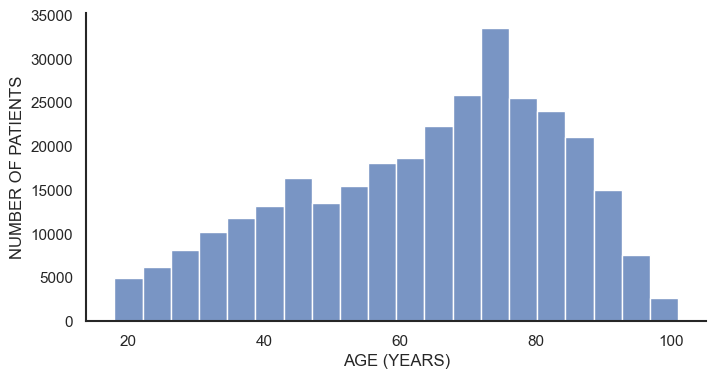

In [146]:
img = sns.histplot(data=df, x='age', bins=20)
img.set_ylabel('NUMBER OF PATIENTS')
img.set_xlabel('AGE (YEARS)')
fig = img.get_figure()
fig.savefig('Age histogram.tiff', dpi=600, bbox_inches='tight')

In [147]:
df.groupby('outcome')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
outcome,,,,,,,,
death,98626.0,71.289660,16.063895,18.0,62.0,74.0,83.0,101.0
survival,216102.0,60.574891,19.604385,18.0,45.0,63.0,76.0,101.0


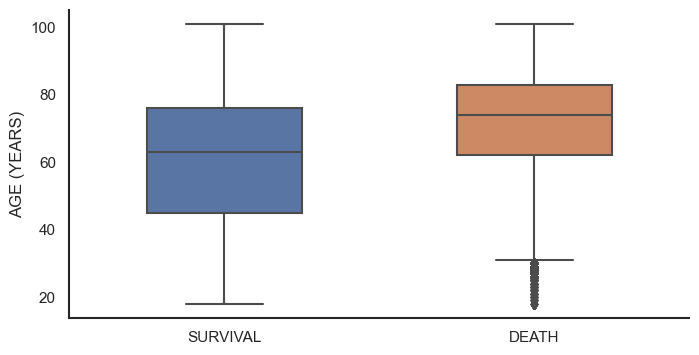

In [148]:
img = sns.boxplot(data=df, x='outcome', y='age', width=0.5)
img.set_ylabel('AGE (YEARS)')
img.set_xlabel(None)
img.set_xticklabels(['SURVIVAL', 'DEATH'])
fig = img.get_figure()
fig.savefig('Age boxplot.tiff', dpi=600, bbox_inches='tight')

### Sex

In [149]:
sex = df.groupby('sex')['outcome'].value_counts().unstack()
sex

outcome,death,survival
sex,,
female,44698,104866
male,53921,111222


### Race

In [150]:
race = df.groupby('race')['outcome'].value_counts().unstack()
race

outcome,death,survival
race,,
asian,955,2097
black,4523,7909
indigenous,156,349
mixed,31288,66297
white,47805,102452


### Education

In [151]:
ed = df.groupby('education')['outcome'].value_counts().unstack()
ed

outcome,death,survival
education,,
illiterate,4294,5144
5_grade,13525,19973
9_grade,7195,13126
12_grade,8548,22466
higher_ed,3507,10517


In [152]:
dem_table = pd.concat([sex, race, ed])
dem_table.to_excel('Demograpics_table.xlsx')
dem_table

outcome,death,survival
female,44698,104866
male,53921,111222
asian,955,2097
black,4523,7909
indigenous,156,349
mixed,31288,66297
white,47805,102452
illiterate,4294,5144
5_grade,13525,19973
9_grade,7195,13126


## 3.2 Vaccination

### Time between hospitalization and vaccination

In [154]:
def get_vac_dose_label(first, second, booster): 
    if booster == 1: 
        return 'BOOSTER DOSE'
    elif second == 1: 
        return 'SECOND DOSE'
    elif first == 1: 
        return 'FIRST DOSE'
    else:
        return 'NO DATE'

# Testing get_vac_dose_label: 
print(get_vac_dose_label(1,1,1) == 'BOOSTER DOSE')
print(get_vac_dose_label(1,1,0) == 'SECOND DOSE')
print(get_vac_dose_label(1,0,0) == 'FIRST DOSE')
print(get_vac_dose_label(0,0,0) == 'NO DATE')
    
df['vac_dose_label'] = np.vectorize(get_vac_dose_label)(df['first_dose_date'],
                                                        df['second_dose_date'], 
                                                        df['booster_date'])
vac_cat = ['BOOSTER DOSE', 'SECOND DOSE', 'FIRST DOSE', 'NO DATE']
df['vac_dose_label'] = pd.Categorical(df['vac_dose_label'], categories=vac_cat) 
df['vac_dose_label'].value_counts().sort_index()

True
True
True
True


BOOSTER DOSE     58234
SECOND DOSE     110722
FIRST DOSE       30758
NO DATE         115014
Name: vac_dose_label, dtype: int64

In [155]:
df[df['vac_dose_label'] == 'BOOSTER DOSE'][vaccination].head()

,vaccination_status,first_dose_date,second_dose_date,booster_date,timedelta_hosp_vac
1019,vaccinated,1,1,1,163.0
1106,vaccinated,1,1,1,97.0
1112,vaccinated,1,1,1,10.0
2107,vaccinated,1,1,1,13.0
2163,vaccinated,1,1,1,49.0


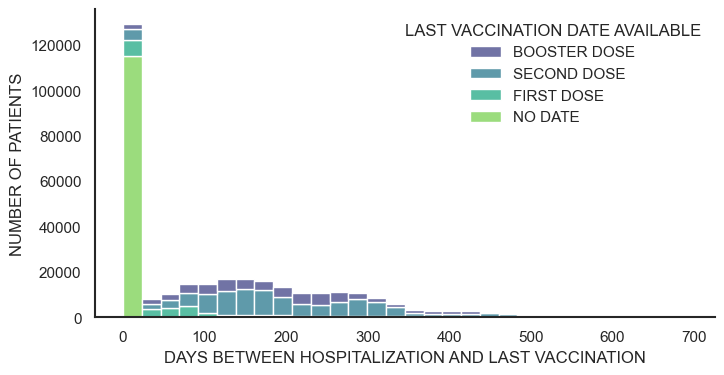

In [156]:
# Histogram with hue separating patients with the first date of vaccination filled out
img = sns.histplot(x='timedelta_hosp_vac', data=df,  hue='vac_dose_label',
                   multiple='stack', bins=30, palette='viridis')
img.set_ylabel('NUMBER OF PATIENTS')
img.set_xlabel('DAYS BETWEEN HOSPITALIZATION AND LAST VACCINATION')
leg = img.get_legend()
leg.set_title('LAST VACCINATION DATE AVAILABLE')
leg.set_frame_on(False)
fig = img.get_figure()
fig.savefig('Days_hosp_last_vac.tiff', dpi=600, bbox_inches='tight')

In [157]:
vac_table = pd.DataFrame(columns=['odds_ratio', 'pvalue'])
vac_table_cont = pd.DataFrame(columns=['death', 'survival'])

for vac in vaccination[:-1]:
    cont_table = df.groupby(vac)['outcome'].value_counts().unstack()[['death', 'survival']]
    if cont_table.index.dtype == 'int64':
        cont_table = cont_table.reindex([1,0])
    fisher = fisher_exact(cont_table) 
    fisher = round(fisher.pvalue, 2)
    fisher = (lambda x: str(x) if x >= 0.01 else '<0.01')(fisher)
    odds = odds_ratio(cont_table)
    odds_stat = round(odds.statistic, 2)
    ci = odds.confidence_interval(0.95)
    vac_table.loc[vac, 'odds_ratio'] = f'{odds_stat} ({round(ci.low, 2)}-{round(ci.high, 2)})'
    vac_table.loc[vac, 'pvalue'] = fisher
    cont_table.reset_index(inplace=True)
    cont_table.rename({vac:'category'}, axis=1, inplace=True)
    cont_table.index = [vac]*2
    vac_table_cont = pd.concat([vac_table_cont, cont_table])

vac_table = vac_table_cont.join(vac_table)
vac_table = vac_table.reindex(['category', 'death', 'survival', 
                               'odds_ratio', 'pvalue'], axis=1).copy()
vac_table.to_excel('vaccination_table.xlsx')
vac_table

,category,death,survival,odds_ratio,pvalue
booster_date,1,16723,41511,0.86 (0.84-0.88),<0.01
booster_date,0,81903,174591,0.86 (0.84-0.88),<0.01
first_dose_date,1,64752,134962,1.15 (1.13-1.17),<0.01
first_dose_date,0,33874,81140,1.15 (1.13-1.17),<0.01
second_dose_date,1,56736,112220,1.25 (1.23-1.27),<0.01
second_dose_date,0,41890,103882,1.25 (1.23-1.27),<0.01
vaccination_status,vaccinated,64692,134909,1.14 (1.12-1.16),<0.01
vaccination_status,unvaccinated,23775,56284,1.14 (1.12-1.16),<0.01


## 3.3 Comorbidities

In [159]:
comorb_table = pd.DataFrame(columns=['odds_ratio', 'pvalue'])
comorb_table_cont = pd.DataFrame(columns=['death', 'survival'])

for comorb in comorbidities: 
    cont_table = df.groupby(comorb)['outcome'].value_counts().unstack()[['death', 'survival']]
    fisher = fisher_exact(cont_table) 
    fisher = round(fisher.pvalue, 2)
    fisher = (lambda x: str(x) if x >= 0.01 else '<0.01')(fisher)
    odds = odds_ratio(cont_table)
    odds_stat = round(odds.statistic, 2)
    ci = odds.confidence_interval(0.95)
    comorb_table.loc[comorb, 'odds_ratio'] = f'{odds_stat} ({round(ci.low, 2)}-{round(ci.high, 2)})'
    comorb_table.loc[comorb, 'pvalue'] = fisher
    cont_table.reset_index(inplace=True)
    cont_table.rename({comorb:'category'}, axis=1, inplace=True)
    cont_table.index = [comorb]*2
    comorb_table_cont = pd.concat([comorb_table_cont, cont_table])

comorb_table = comorb_table_cont.join(comorb_table)
comorb_table = comorb_table.reindex(['category', 'death', 
                                     'survival', 'odds_ratio', 'pvalue'], 
                                    axis=1).copy()
comorb_table.to_excel('Comorbidity_table.xlsx')
comorb_table

,category,death,survival,odds_ratio,pvalue
asthma,asthma,1948,5670,0.62 (0.59-0.65),<0.01
asthma,no_asthma,42455,76391,0.62 (0.59-0.65),<0.01
blood_disease,blood_disease,1192,1727,1.27 (1.18-1.37),<0.01
blood_disease,no_blood_disease,43126,79340,1.27 (1.18-1.37),<0.01
diabetes,diabetes,28211,45570,1.19 (1.17-1.22),<0.01
diabetes,no_diabetes,27450,52824,1.19 (1.17-1.22),<0.01
heart_disease,heart_disease,42271,67537,1.29 (1.27-1.32),<0.01
heart_disease,no_heart_disease,18824,38914,1.29 (1.27-1.32),<0.01
immunocompromised,immunocompromised,5107,6401,1.5 (1.44-1.56),<0.01
immunocompromised,no_immunocompromised,40444,75892,1.5 (1.44-1.56),<0.01


## 3.4 Signs and Symptoms

In [160]:
symp_table = pd.DataFrame(columns=['odds_ratio', 'pvalue'])
symp_table_cont = pd.DataFrame(columns=['death', 'survival'])

for symp in signs_symptoms: 
    cont_table = df.groupby(symp)['outcome'].value_counts().unstack()[['death', 'survival']]
    fisher = fisher_exact(cont_table) 
    fisher = round(fisher.pvalue, 2)
    fisher = (lambda x: str(x) if x >= 0.01 else '<0.01')(fisher)
    odds = odds_ratio(cont_table)
    odds_stat = round(odds.statistic, 2)
    ci = odds.confidence_interval(0.95)
    symp_table.loc[symp, 'odds_ratio'] = f'{odds_stat} ({round(ci.low, 2)}-{round(ci.high, 2)})'
    symp_table.loc[symp, 'pvalue'] = fisher
    cont_table.reset_index(inplace=True)
    cont_table.rename({symp:'category'}, axis=1, inplace=True)
    cont_table.index = [symp]*2
    symp_table_cont = pd.concat([symp_table_cont, cont_table])

symp_table = symp_table_cont.join(symp_table)
symp_table = symp_table.reindex(['category', 'death', 'survival', 
                                 'odds_ratio', 'pvalue'], axis=1).copy()
symp_table.to_excel('Symptoms_table.xlsx')
symp_table

,category,death,survival,odds_ratio,pvalue
abdominal_pain,abdominal_pain,5393,14078,0.88 (0.85-0.91),<0.01
abdominal_pain,no_abdominal_pain,55346,126646,0.88 (0.85-0.91),<0.01
cough,cough,58177,147606,0.7 (0.68-0.71),<0.01
cough,no_cough,21937,38735,0.7 (0.68-0.71),<0.01
diarrhea,diarrhea,8987,21927,0.94 (0.91-0.96),<0.01
diarrhea,no_diarrhea,53529,122235,0.94 (0.91-0.96),<0.01
dyspnea,dyspnea,72398,129915,2.2 (2.15-2.25),<0.01
dyspnea,no_dyspnea,12512,49414,2.2 (2.15-2.25),<0.01
fatigue,fatigue,23135,52569,1.02 (1.0-1.04),0.05
fatigue,no_fatigue,42093,97531,1.02 (1.0-1.04),0.05


# 4. Machine Learning Models

In [161]:
from scipy.stats import randint, uniform
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
from catboost import CatBoostClassifier
from boruta import BorutaPy
import graphviz
import shap

## 4.1 Preprocessing of training and test sets

### Features

In [162]:
# Features
X = pd.DataFrame()

### continous variables ###
X = pd.concat([X, df[['age'] + [vaccination[-1]]]], axis = 1)

### categorical variables ###
# sex 
sex = pd.get_dummies(df['sex'], dummy_na=True, drop_first=True)
sex.columns = sex.columns.fillna('missing_sex')

# race 
race = pd.get_dummies(df['race'], dummy_na=True, drop_first=True)
race.columns = race.columns.fillna('missing_race')

# education
education = pd.get_dummies(df['education'], dummy_na=True, drop_first=True)
education.columns = education.columns.fillna('missing_education')

# vaccination 
vaccination_status = pd.get_dummies(df['vaccination_status'], dummy_na=True, drop_first=True)
vaccination_status.columns = vaccination_status.columns.fillna('missing_vaccination')

# vaccination dates
vaccination_dates = df[vaccination[1:-1]]

X = pd.concat([X, sex, race, education, vaccination_status, vaccination_dates], axis=1)

# comorbidities and symptoms
comorb_symp = comorbidities + signs_symptoms

for column in comorb_symp: 
    dummies = pd.get_dummies(df[column], dummy_na=True)
    dummies.drop(columns=f'no_{column}', inplace=True)
    dummies.columns = dummies.columns.fillna(f'missing_{column}')
    X = pd.concat([X, dummies], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314728 entries, 0 to 314727
Data columns (total 65 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   age                        314728 non-null  int64  
 1   timedelta_hosp_vac         314728 non-null  float64
 2   male                       314728 non-null  uint8  
 3   missing_sex                314728 non-null  uint8  
 4   black                      314728 non-null  uint8  
 5   indigenous                 314728 non-null  uint8  
 6   mixed                      314728 non-null  uint8  
 7   white                      314728 non-null  uint8  
 8   missing_race               314728 non-null  uint8  
 9   5_grade                    314728 non-null  uint8  
 10  9_grade                    314728 non-null  uint8  
 11  12_grade                   314728 non-null  uint8  
 12  higher_ed                  314728 non-null  uint8  
 13  missing_education          31

### Target variable

In [163]:
# Target variable
y = pd.get_dummies(df['outcome']).drop(columns='survival')['death']
y

0         0
1         0
2         0
3         1
4         1
         ..
314723    0
314724    0
314725    0
314726    1
314727    0
Name: death, Length: 314728, dtype: uint8

### Train-test split

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                    random_state=42,
                                                    shuffle=True)
print(X_train.shape)
print(X_test.shape)

(220309, 65)
(94419, 65)


### Z score transformation

In [165]:
continuous_col = ['age', 'timedelta_hosp_vac'] # continuous variables

scaler = ColumnTransformer([('scaler', StandardScaler(), continuous_col)], 
                           remainder='passthrough') # this will keep the other columns intact
  
scaler.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['age', 'timedelta_hosp_vac'])])

In [166]:
X_train = scaler.transform(X_train) # returns an array
X_train = pd.DataFrame(X_train, columns=X.columns) # converts the data back to a dataframe
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220309 entries, 0 to 220308
Data columns (total 65 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   age                        220309 non-null  float64
 1   timedelta_hosp_vac         220309 non-null  float64
 2   male                       220309 non-null  float64
 3   missing_sex                220309 non-null  float64
 4   black                      220309 non-null  float64
 5   indigenous                 220309 non-null  float64
 6   mixed                      220309 non-null  float64
 7   white                      220309 non-null  float64
 8   missing_race               220309 non-null  float64
 9   5_grade                    220309 non-null  float64
 10  9_grade                    220309 non-null  float64
 11  12_grade                   220309 non-null  float64
 12  higher_ed                  220309 non-null  float64
 13  missing_education          22

In [167]:
X_test = scaler.transform(X_test) # returns an array
X_test = pd.DataFrame(X_test, columns=X.columns) # converts the data back to a dataframe
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94419 entries, 0 to 94418
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        94419 non-null  float64
 1   timedelta_hosp_vac         94419 non-null  float64
 2   male                       94419 non-null  float64
 3   missing_sex                94419 non-null  float64
 4   black                      94419 non-null  float64
 5   indigenous                 94419 non-null  float64
 6   mixed                      94419 non-null  float64
 7   white                      94419 non-null  float64
 8   missing_race               94419 non-null  float64
 9   5_grade                    94419 non-null  float64
 10  9_grade                    94419 non-null  float64
 11  12_grade                   94419 non-null  float64
 12  higher_ed                  94419 non-null  float64
 13  missing_education          94419 non-null  flo

In [168]:
X_test['age'].describe()

count    94419.000000
mean        -0.000523
std          1.000827
min         -2.390413
25%         -0.725185
50%          0.159467
75%          0.783928
max          1.928772
Name: age, dtype: float64

In [169]:
X_test['timedelta_hosp_vac'].describe()

count    94419.000000
mean         0.002884
std          1.005172
min         -0.908570
25%         -0.908570
50%         -0.250580
75%          0.655124
max          4.440502
Name: timedelta_hosp_vac, dtype: float64

In [170]:
# Dataframe with the metrics from all the models:
df_models = pd.DataFrame()
df_models.index.name = 'Model'

## 4.2 Model training and optimization

### Decision tree

#### Default hyperparameters

In [171]:
# Default hyperparameters
model_name = 'Decision Tree'
print(model_name, '- Default Hyperparameters') 

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Model Prediction
y_pred = dt_clf.predict(X_test)
prob_pos = dt_clf.predict_proba(X_test)[:,1]

# Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
print("AUC: {:.4f}".format(auc))

Decision Tree - Default Hyperparameters
Accuracy: 0.6295
Precision: 0.4103
Recall: 0.4245
F1 score: 0.4173
AUC: 0.5746


#### Optimized hyperparameters

In [172]:
model_name = 'Decision Tree'
print(model_name, '- Optimized Hyperparameters')

dt_clf = DecisionTreeClassifier(random_state=42)
np.random.seed(42)

# Defining hyperparameters to search over
param_dist = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [3, 5, 7, 9, 11, 13, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

# Defining randomized search with 10 iterations and 5-fold cross-validation
cv_dt = RandomizedSearchCV(
    dt_clf, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=5,
    random_state=42,
    n_jobs=-1
)
    
# Fitting randomized search to training data
cv_dt.fit(X_train, y_train)
print(cv_dt.best_params_)

# Training the best tree
best_dt_clf = cv_dt.best_estimator_
best_dt_clf.fit(X_train, y_train)

# Model prediction
ypred = best_dt_clf.predict(X_test)
prob_pos = best_dt_clf.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Decision Tree - Optimized Hyperparameters
{'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 9, 'criterion': 'gini'}
Accuracy: 0.6295
Precision: 0.4103
Recall: 0.4245
F1 score: 0.4173
AUC: 0.7156


#### Exporting the tree with high resolution

In [173]:
dot_data = export_graphviz(best_dt_clf, out_file='tree.gv', 
                           feature_names=X.columns,  
                           class_names={1:'death', 0:'survival'},
                           max_depth=3,
                           filled=True)

Run the following comands on the Terminal:
1) cd 'current_working_directory'
2) dot -Tpng -Gdpi=300 tree.gv -o tree.png

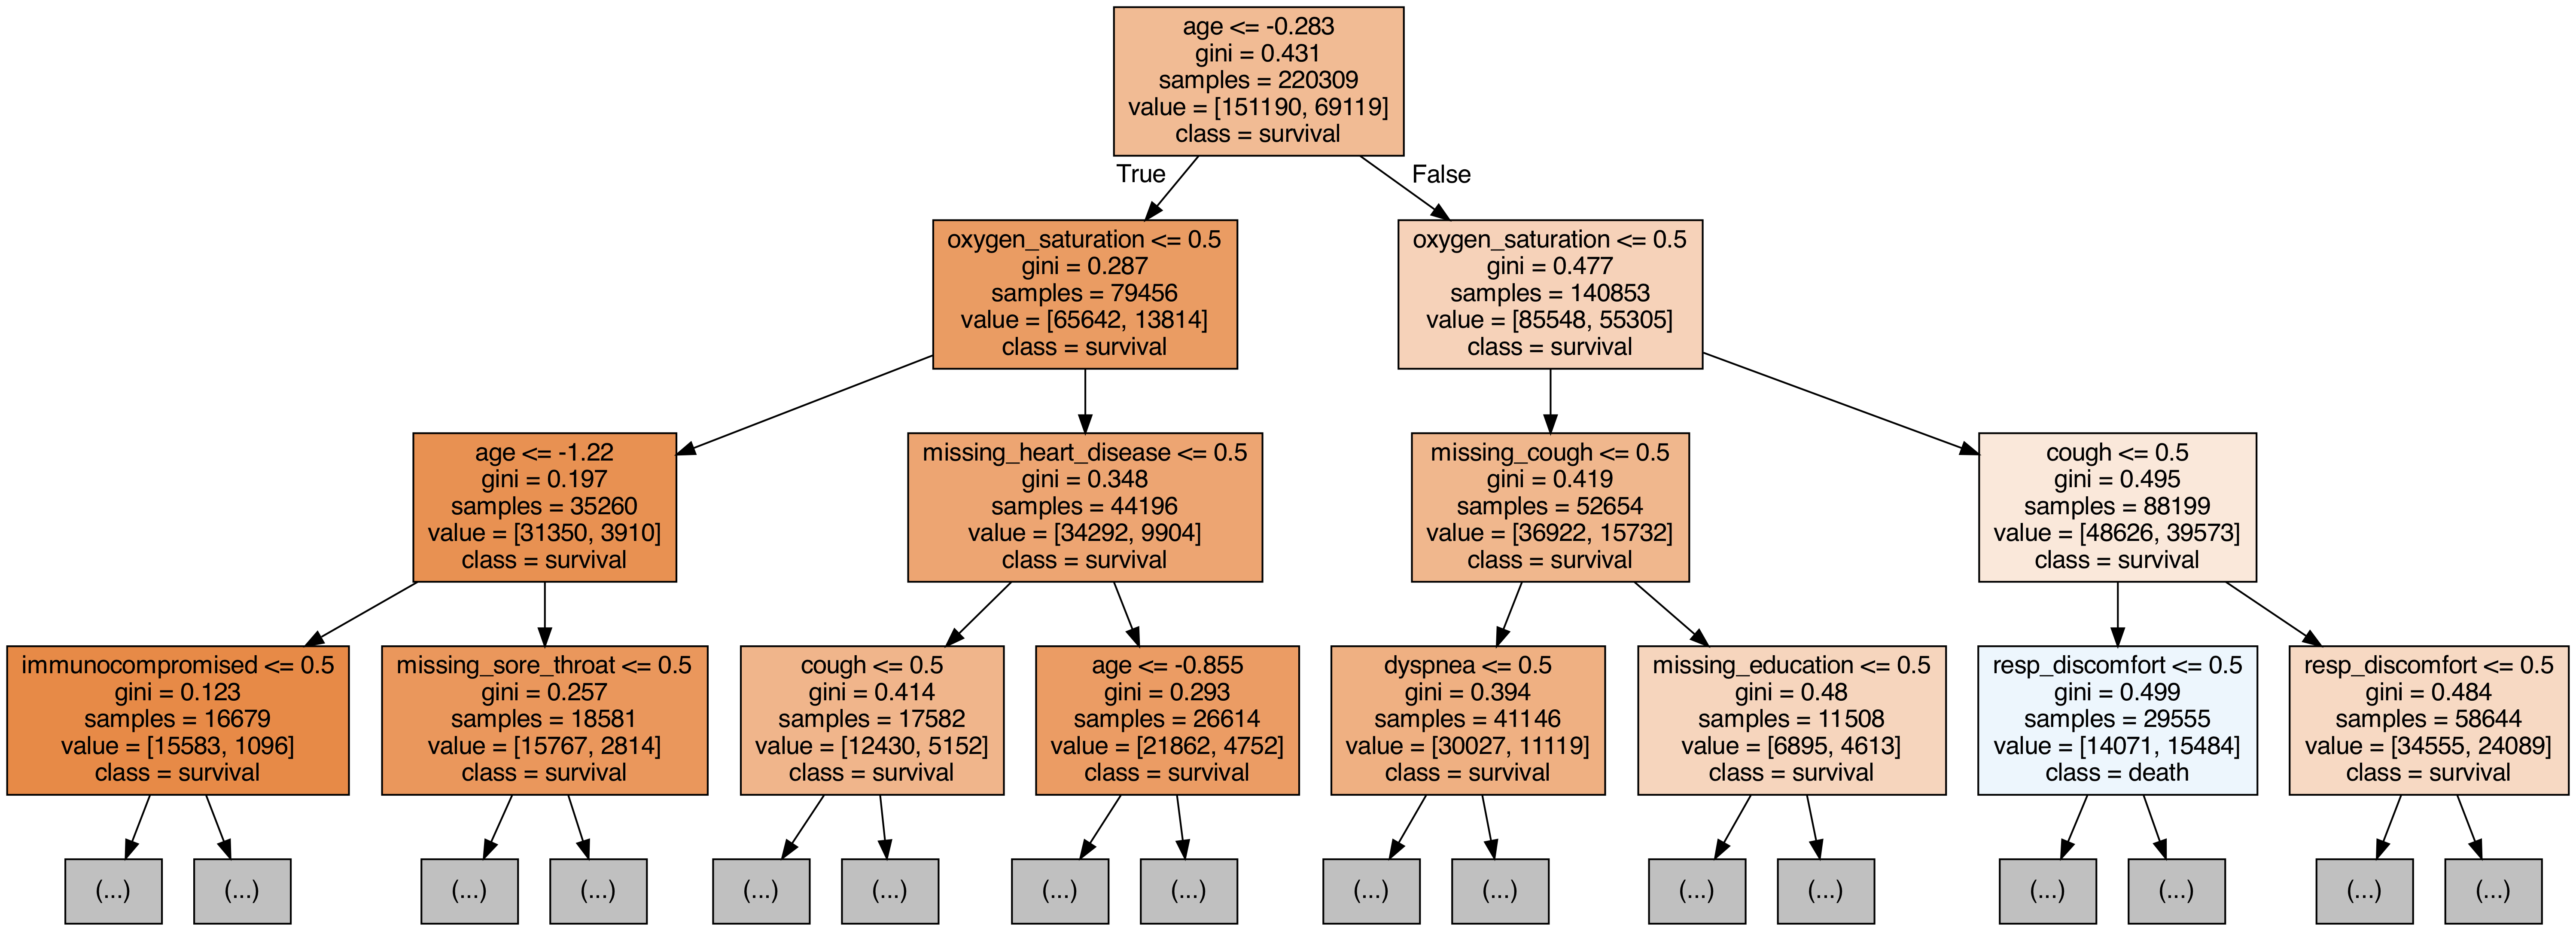

In [206]:
from IPython.display import Image
Image(filename='tree.png') 

__________

### Random Forest

#### Default hyperparameters

In [175]:
model_name = 'Random Forest'
print(model_name, '- Default Hyperparameters')

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# Model prediction
y_pred = rf_clf.predict(X_test)
prob_pos = rf_clf.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
print("AUC: {:.4f}".format(auc))

Random Forest - Default Hyperparameters
Accuracy: 0.6986
Precision: 0.5279
Recall: 0.3362
F1 score: 0.4108
AUC: 0.7012


#### Optimized hyperparameters

In [176]:
model_name = 'Random Forest'
print(model_name, '- Optimized Hyperparameters')

rf_clf = RandomForestClassifier(random_state=42)
np.random.seed(42)

# Defining hyperparameters to search over
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 9, 11, 13, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'oob_score': [True, False],
}

# Defining randomized search with 10 iterations and 5-fold cross-validation
cv_rf = RandomizedSearchCV(
    rf_clf, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=5, 
    random_state=42,
    n_jobs=-1
)

# Fitting randomized search to training data
cv_rf.fit(X_train, y_train)
print(cv_rf.best_params_)

# Model predictions
y_pred = cv_rf.predict(X_test)
prob_pos = cv_rf.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Random Forest - Optimized Hyperparameters
{'oob_score': False, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
Accuracy: 0.7155
Precision: 0.5831
Recall: 0.3148
F1 score: 0.4088
AUC: 0.7309


________

### XGBoost

#### Default hyperparameters

In [177]:
model_name = 'XGBoost'
print(model_name, '- Default Hyperparameters')

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_clf.fit(X_train, y_train)

# Model predictions
y_pred = xgb_clf.predict(X_test)
prob_pos = xgb_clf.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
print("AUC: {:.4f}".format(auc))

XGBoost - Default Hyperparameters
Accuracy: 0.7202
Precision: 0.5887
Recall: 0.3475
F1 score: 0.4370
AUC: 0.7389


#### Optimized hyperparameters

In [178]:
model_name = 'XGBoost'
print(model_name, '- Optimized Hyperparameters')

xgb_clf = xgb.XGBClassifier(random_state=42)
np.random.seed(42)

# Defining hyperparameters to search over
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 3, 5, 7, 9],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'objective': ['binary:logistic'],
    'eval_metric': ['auc', 'accuracy'],
}

# Defining randomized search with 10 iterations and 5-fold cross-validation
cv_xgb = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fitting the randomized search to some data X and labels y
cv_xgb.fit(X_train, y_train)
print(cv_xgb.best_params_)

# Mode predictions 
y_pred = cv_xgb.predict(X_test)
prob_pos = cv_xgb.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

XGBoost - Optimized Hyperparameters
{'subsample': 0.8, 'objective': 'binary:logistic', 'n_estimators': 300, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.3, 'eval_metric': 'auc', 'colsample_bytree': 0.8}
Accuracy: 0.7213
Precision: 0.5942
Recall: 0.3415
F1 score: 0.4338
AUC: 0.7424


______

### CatBoost

#### Default hyperparameters

In [179]:
model_name = 'CatBoost'
print(model_name, '- Default Hyperparameters')

cat_clf = CatBoostClassifier(random_state=42, silent=True)
cat_clf.fit(X_train, y_train)

# Model predictions
y_pred = cat_clf.predict(X_test)
prob_pos = cat_clf.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

CatBoost - Default Hyperparameters
Accuracy: 0.7213
Precision: 0.5933
Recall: 0.3445
F1 score: 0.4359
AUC: 0.7424


#### Optimized hyperparameters

In [180]:
model_name = 'CatBoost'
print(model_name, '- Optimized Hyperparameters')

cat_clf = CatBoostClassifier(random_state=42, silent=True)
np.random.seed(42)

# Defining hyperparameters to search over
param_dist = {
    'depth': [4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.03, 0.1, 0.15, 0.2],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [100, 200, 300, 400, 500],
    'random_strength': [0.01, 0.1, 1, 10, 100],
    'border_count': [32, 64, 96, 128],
    'loss_function': ['Logloss', 'CrossEntropy'],
    'eval_metric': ['AUC', 'Accuracy'],
    'boosting_type': ['Plain', 'Ordered', 'PlainWithEarlyStopping', 'OrderedWithEarlyStopping'],
}

# Defining randomized search with 10 iterations and 5-fold cross-validation
cv_cat = RandomizedSearchCV(
    cat_clf, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=5, 
    random_state=42,
    n_jobs=-1
)

# Fitting randomized search to training data
cv_cat.fit(X_train, y_train)
print(cv_cat.best_params_)

# Model predictions
y_pred = cv_cat.predict(X_test)
prob_pos = cv_cat.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

CatBoost - Optimized Hyperparameters
{'random_strength': 0.1, 'loss_function': 'CrossEntropy', 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 500, 'eval_metric': 'AUC', 'depth': 10, 'border_count': 128, 'boosting_type': 'Plain'}
Accuracy: 0.7214
Precision: 0.5965
Recall: 0.3353
F1 score: 0.4293
AUC: 0.7431


_____

### Multilinear Perceptron

#### Default hyperparameters

In [181]:
model_name = 'Multilinear Perceptron'
print(model_name, '- Default Hyperparameters')

mlp_clf = MLPClassifier(random_state=42)
mlp_clf.fit(X_train, y_train)

# Model predictions
y_pred = mlp_clf.predict(X_test)
prob_pos = mlp_clf.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
print("AUC: {:.4f}".format(auc))

Multilinear Perceptron - Default Hyperparameters
Accuracy: 0.7132
Precision: 0.5597
Recall: 0.3847
F1 score: 0.4560
AUC: 0.7297


#### Optimized hyperparameters

In [182]:
model_name = 'Multilinear Perceptron'
print(model_name, '- Optimized Hyperparameters')

mlp_clf = MLPClassifier(random_state=42)
np.random.seed(42)

# Defining hyperparameters to search over
param_dist = {
    'hidden_layer_sizes': randint(1, 100),
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [1000]
}

# Defining randomized search with 10 iterations and 5-fold cross-validation
cv_mlp = RandomizedSearchCV(
    mlp_clf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fitting randomized search to training data
cv_mlp.fit(X_train, y_train)
print(cv_mlp.best_params_)

# Model predictions
y_pred = cv_mlp.predict(X_test)
prob_pos = cv_mlp.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Multilinear Perceptron - Optimized Hyperparameters
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 92, 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'sgd'}
Accuracy: 0.7205
Precision: 0.5937
Recall: 0.3343
F1 score: 0.4278
AUC: 0.7394


____

______

### Logistic Regression

#### Default hyperparameters

In [185]:
model_name = 'Logistic Regression'
print(model_name, 'Default Hyperparameters')

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Model predictions
y_pred = lr.predict(X_test)
prob_pos = lr.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
print("AUC: {:.4f}".format(auc))

Logistic Regression Default Hyperparameters
Accuracy: 0.7166
Precision: 0.5860
Recall: 0.3173
F1 score: 0.4117
AUC: 0.7324


#### Optimized hyperparameters

In [186]:
model_name = 'Logistic Regression'
print(model_name, '- Optimized Hyperparameters')

lr = LogisticRegression(random_state=42)
np.random.seed(42)

# Defining hyperparameters to search over
param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': uniform(0, 10),
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 1000, 10000]
}

# Defining randomized search with 10 iterations and 5-fold cross-validation
cv_lr = RandomizedSearchCV(
    lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fitting randomized search to training data
cv_lr.fit(X_train, y_train)
print(cv_lr.best_params_)

# Model predictions 
y_pred = cv_lr.predict(X_test)
prob_pos = cv_lr.predict_proba(X_test)[:,1]

# Model performance
accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

Logistic Regression - Optimized Hyperparameters
{'C': 4.592488919658671, 'fit_intercept': True, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'saga'}
Accuracy: 0.7166
Precision: 0.5862
Recall: 0.3171
F1 score: 0.4116
AUC: 0.7324


In [187]:
df_models.to_excel('Machine_learning_metrics.xlsx')
df_models

,Accuracy,Precision,Recall,F1 score,AUC
Model,,,,,
Decision Tree,0.6295,0.4103,0.4245,0.4173,0.7156
Random Forest,0.7155,0.5831,0.3148,0.4088,0.7309
XGBoost,0.7213,0.5942,0.3415,0.4338,0.7424
CatBoost,0.7214,0.5965,0.3353,0.4293,0.7431
Multilinear Perceptron,0.7205,0.5937,0.3343,0.4278,0.7394
K-Nearest Neighbors,0.6793,0.4816,0.3448,0.4019,0.6538
Logistic Regression,0.7166,0.5862,0.3171,0.4116,0.7324


## 4.3 Using Boruta for feature selection 

In [188]:
# Using Random Forest as estimator
rf = RandomForestClassifier(random_state=42, 
                            n_jobs = -1, 
                            max_depth = 5) 

boruta = BorutaPy(estimator = rf, 
                  n_estimators = 'auto',
                  max_iter = 100)
boruta.fit(np.array(X_train), np.array(y_train)) 

# Determining the best features
green_area = X_train.columns[boruta.support_].to_list()
blue_area = X_train.columns[boruta.support_weak_].to_list()
print('features in the green area:', green_area)
print('features in the blue area:', blue_area)

n_features = X_train.shape[1]
n_features_boruta = X_train[green_area].shape[1]
print(f'Boruta has eliminated {n_features - n_features_boruta} features')

features in the green area: ['age', 'timedelta_hosp_vac', 'male', 'missing_race', '5_grade', '12_grade', 'higher_ed', 'missing_education', 'first_dose_date', 'second_dose_date', 'booster_date', 'diabetes', 'missing_diabetes', 'obesity', 'missing_obesity', 'lung_disease', 'missing_lung_disease', 'liver_disease', 'missing_liver_disease', 'heart_disease', 'missing_heart_disease', 'kidney_disease', 'missing_kidney_disease', 'asthma', 'missing_asthma', 'missing_blood_disease', 'immunocompromised', 'missing_immunocompromised', 'pregnancy', 'missing_pregnancy', 'neuro_disease', 'missing_neuro_disease', 'fever', 'missing_fever', 'cough', 'missing_cough', 'sore_throat', 'missing_sore_throat', 'dyspnea', 'missing_dyspnea', 'resp_discomfort', 'missing_resp_discomfort', 'oxygen_saturation', 'missing_oxygen_saturation', 'missing_diarrhea', 'missing_vomiting', 'missing_abdominal_pain', 'fatigue', 'missing_fatigue', 'loss_smell', 'missing_loss_smell', 'loss_taste', 'missing_loss_taste']
features in t

In [189]:
cat_boruta = cv_cat.best_estimator_
cat_boruta.fit(X_train[green_area], y_train)

y_pred = cat_boruta.predict(X_test[green_area])
prob_pos = cat_boruta.predict_proba(X_test[green_area])[:,1]

model_name = 'CatBoost'
print(model_name, '- Boruta')

accuracy = accuracy_score(y_test, y_pred)
df_models.loc[model_name, 'Accuracy'] = round(accuracy, 4) 
print(("Accuracy: {:.4f}".format(accuracy)))

precision = precision_score(y_test, y_pred)
df_models.loc[model_name, 'Precision'] = round(precision, 4) 
print("Precision: {:.4f}".format(precision))

recall = recall_score(y_test, y_pred)
df_models.loc[model_name, 'Recall'] = round(recall, 4) 
print("Recall: {:.4f}".format(recall))

f1 = f1_score(y_test, y_pred)
df_models.loc[model_name, 'F1 score'] = round(f1, 4) 
print("F1 score: {:.4f}".format(f1))

auc = roc_auc_score(y_test, prob_pos)
df_models.loc[model_name, 'AUC'] = round(auc, 4) 
print("AUC: {:.4f}".format(auc))

CatBoost - Boruta
Accuracy: 0.7202
Precision: 0.5936
Recall: 0.3323
F1 score: 0.4261
AUC: 0.7415


## 4.4 Shapley Values

In [190]:
# Best model 
best_cat_clf = cv_cat.best_estimator_
best_cat_clf.fit(X_train, y_train)
y_pred = best_cat_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7214014128512269

In [196]:
def format_labels(label: str): 
    if label == 'resp_discomfort':
        label = 'respiratory_discomfort'
    elif label == 'oxygen_saturation':
        label = 'oxygen_saturation_<95%'
    elif label == 'timedelta_hosp_vac':
        label = 'time_hospital_-_last_vaccine'
    label = label.upper()
    words = label.split('_')
    return " ".join(words)

# Testing format_labels: 
print(format_labels('dyspnea') == 'DYSPNEA')
print(format_labels('resp_discomfort') == 'RESPIRATORY DISCOMFORT')
print(format_labels('oxygen_saturation') == 'OXYGEN SATURATION <95%')

True
True
True


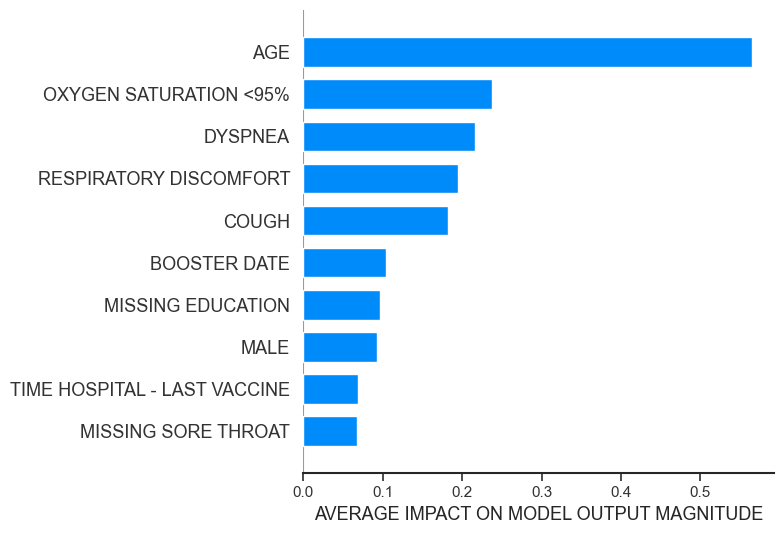

In [197]:
figure_labels = [format_labels(x) for x in X.columns]

shap_values_test = shap.TreeExplainer(best_cat_clf).shap_values(X_test)
shap.summary_plot(shap_values_test, X_test, 
                  max_display=10, feature_names=figure_labels,
                  plot_type="bar", show=False)
plt.xlabel('AVERAGE IMPACT ON MODEL OUTPUT MAGNITUDE')
plt.savefig('shap_summary_bar.tiff', dpi=300)

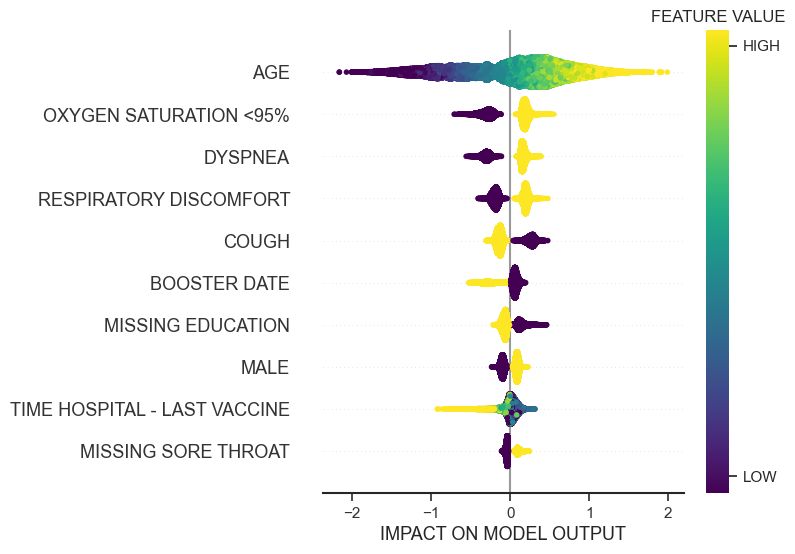

In [205]:
shap.summary_plot(shap_values_test, X_test, 
                  max_display=10, cmap='viridis', 
                  feature_names=figure_labels, show=False,
                  color_bar=False)
plt.xlabel('IMPACT ON MODEL OUTPUT')
colorbar = plt.colorbar()
colorbar.ax.set_title('FEATURE VALUE')
colorbar.set_ticks(ticks=[-1.7, 1.3], labels=['LOW', 'HIGH'])
colorbar.outline.set_visible(False)
plt.savefig('shap_summary_values.tiff', dpi=300)